In [3]:
from re import A
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma import right_shift
import pandas as pd
from collections import Counter
from scipy.spatial import KDTree
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from random import Random, random, randrange
from joblib import Parallel, delayed
# from numba import njit, int32, float32, jit, prange
# from numba.experimental import jitclass
# from numba.typed import Dict, List
# import numba
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import cython 
from cython.parallel import prange, parallel
from sklearn import datasets

In [2]:
%load_ext cython

In [4]:
nmr_peaks = pd.read_csv('~/Documents/IBS/NMR_data/IBS_HNMR_data_n267.csv')

# y = np.array(nmr_peaks.iloc[:, 1])


X = np.array(nmr_peaks.iloc[:10, 3:10])
scaler = StandardScaler()
pca_df = scaler.fit_transform(X)
            # pca_df = X[:, indeces] # takes value for relevant feature in all training samples
pca = PCA(n_components=7, svd_solver='full')
X_pca = pca.fit_transform(pca_df)
display(pca.components_)

def svd_flip(u, v, u_based_decision=True):
    if u_based_decision:
        # columns of u, rows of v
        max_abs_cols = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_cols, range(u.shape[1])])
        u *= signs
        v *= signs[:, np.newaxis]
    else:
        # rows of v, columns of u
        max_abs_rows = np.argmax(np.abs(v), axis=1)
        signs = np.sign(v[range(v.shape[0]), max_abs_rows])
        u *= signs
        v *= signs[:, np.newaxis]
    return u, v
n = X.shape[0]
# T = np.zeros((n,n))
# for i in range(n):
#     for j in range(i+1):
#         T[i,j] = np.dot(X[i],X[j])
#         T[j,i] = T[i,j]

u,s,v = np.linalg.svd(pca_df, full_matrices=False)
display(v)
u,v = svd_flip(u,v)
display(v)

array([[-0.40847255, -0.51941533, -0.56554831, -0.25024229,  0.003318  ,
         0.30199289,  0.299468  ],
       [-0.45383163, -0.26512047, -0.02667873, -0.01018929, -0.28701722,
        -0.60118085, -0.52833238],
       [ 0.13203996,  0.34356147, -0.09117636, -0.73451039, -0.51960021,
         0.15009118, -0.15556536],
       [ 0.01730777,  0.11380952, -0.20668742, -0.35146454,  0.76328694,
         0.01587708, -0.48748517],
       [ 0.64311039, -0.09930504, -0.65741155,  0.20254692, -0.13047029,
        -0.28236099, -0.08113017],
       [ 0.40758419, -0.69524023,  0.39124788, -0.13235141, -0.06322597,
         0.28468441, -0.30802859],
       [ 0.17244438, -0.18897431,  0.20771541, -0.46443513,  0.2097588 ,
        -0.6031828 ,  0.51756905]])

array([[ 0.40847255,  0.51941533,  0.56554831,  0.25024229, -0.003318  ,
        -0.30199289, -0.299468  ],
       [-0.45383163, -0.26512047, -0.02667873, -0.01018929, -0.28701722,
        -0.60118085, -0.52833238],
       [-0.13203996, -0.34356147,  0.09117636,  0.73451039,  0.51960021,
        -0.15009118,  0.15556536],
       [ 0.01730777,  0.11380952, -0.20668742, -0.35146454,  0.76328694,
         0.01587708, -0.48748517],
       [-0.64311039,  0.09930504,  0.65741155, -0.20254692,  0.13047029,
         0.28236099,  0.08113017],
       [ 0.40758419, -0.69524023,  0.39124788, -0.13235141, -0.06322597,
         0.28468441, -0.30802859],
       [-0.17244438,  0.18897431, -0.20771541,  0.46443513, -0.2097588 ,
         0.6031828 , -0.51756905]])

array([[-0.40847255, -0.51941533, -0.56554831, -0.25024229,  0.003318  ,
         0.30199289,  0.299468  ],
       [-0.45383163, -0.26512047, -0.02667873, -0.01018929, -0.28701722,
        -0.60118085, -0.52833238],
       [ 0.13203996,  0.34356147, -0.09117636, -0.73451039, -0.51960021,
         0.15009118, -0.15556536],
       [ 0.01730777,  0.11380952, -0.20668742, -0.35146454,  0.76328694,
         0.01587708, -0.48748517],
       [ 0.64311039, -0.09930504, -0.65741155,  0.20254692, -0.13047029,
        -0.28236099, -0.08113017],
       [ 0.40758419, -0.69524023,  0.39124788, -0.13235141, -0.06322597,
         0.28468441, -0.30802859],
       [ 0.17244438, -0.18897431,  0.20771541, -0.46443513,  0.2097588 ,
        -0.6031828 ,  0.51756905]])

In [5]:
def gini_index( y_left, y_right):


    parent_node_y = y_left+y_right
    print(parent_node_y)
    proportion_left = len(y_left) / len(parent_node_y)
    print(proportion_left)
    proportion_right = len(y_right) / len(parent_node_y)
    print(proportion_right)
    p_parent = (np.bincount(np.array(parent_node_y, dtype=np.int64)))/len(parent_node_y)

    p_left = (np.bincount(np.array(y_left, dtype=np.int64)))/len(y_left)
    print(p_left)
    p_right = (np.bincount(np.array(y_right, dtype=np.int64)))/len(y_right)
    print(p_right)
    gini_l = 1-np.sum(p_left**2)
    gini_r = 1-np.sum(p_right**2)
    gini_p = 1-np.sum(p_parent**2)
    
    gini_gain = gini_p - (proportion_left*gini_l + proportion_right*gini_r)
    
    return gini_gain

# display(gini_index([1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]))
gini_index( [0.0] ,[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0])

[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
0.0625
0.9375
[1.]
[0.4 0.6]


0.042187500000000044

In [3]:
%%cython
# distutils: language=c++
import numpy as np
cimport numpy as np
cimport cython
from numpy cimport ndarray, float64_t, int_t
from libcpp cimport bool
from libc.stdlib cimport qsort
from libc.math cimport ceil, sqrt
from cython.parallel import prange, parallel
from cython_wrapper import gbcpp



cdef ndarray[float64_t, ndim=2] get_bootstrap(ndarray[float64_t, ndim=2] data):
    return data[np.random.choice(data.shape[0], 100, replace=True), :]

cpdef bool is_pure(list Y):
    return np.unique(Y).size == 1

cpdef add_endnode(dict node, bool left, bool right):
    cdef int most_common_class
    if left:
        most_common_class = np.bincount(np.array(node['y_left']).astype('int')).argmax()
        node['left_node'] = {'end_node': True, 'y_hat': most_common_class}
        del node['y_left']
    if right:
        most_common_class = np.bincount(np.array(node['y_right']).astype('int')).argmax()
        node['right_node'] = {'end_node': True, 'y_hat': most_common_class}
        del node['y_right']

# void qsort(void *base, size_t nitems, size_t size, int (*compar)(const void *, const void*))

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
#cpdef double gini_index(ndarray[float64_t, ndim=1] y_left, ndarray[float64_t, ndim=1] y_right):
cpdef double gini_index(list y_left, list y_right):
    cdef:
        double gini_gain = 0.0
        #double proportion_left, proportion_right, p_parent, p_left, p_right, gini_l, gini_r, gini_p
    parent_node_y = y_left+y_right
    proportion_left = <double>len(y_left) / len(parent_node_y)
    proportion_right = <double>len(y_right) / len(parent_node_y)
    p_parent = (np.bincount(np.array(parent_node_y, dtype=np.int64)))/len(parent_node_y)

    p_left = (np.bincount(np.array(y_left, dtype=np.int64)))/len(y_left)
    p_right = (np.bincount(np.array(y_right, dtype=np.int64)))/len(y_right)
    gini_l = 1-np.sum(p_left**2)
    gini_r = 1-np.sum(p_right**2)
    gini_p = 1-np.sum(p_parent**2)
    
    gini_gain = gini_p - (proportion_left*gini_l + proportion_right*gini_r)
    return gini_gain

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef dict get_best_split(ndarray[float64_t, ndim=2] data,  ndarray[int_t, ndim=1] features):
    cdef:
        # ndarray[double, ndim=1] y_left, y_right
        # ndarray[double, ndim=1] samples_left, samples_right
        list  df_left, df_right, b_left, b_right, b_samples_right, b_samples_left, b_y_left, b_y_right
        double split_point, b_split_point, gini, b_gini = -1
        int b_predictor, f_idx, predictor, row_i
        # int num_random_predictors = <int>ceil(sqrt(data.shape[1]-1)) # size of random_predictors array
        # ndarray[int_t, ndim=1] random_predictors = np.random.choice(data.shape[1]-1, num_random_predictors, replace=False)
        dict gini_dict
        ndarray[float64_t, ndim=1] loading_weight
        double node_gini
        
    
        # N = int(max(1, int(np.sqrt(N))))

        ndarray[double, ndim=1] bcvar = np.zeros(1, dtype=np.double)

        ndarray[double, ndim=1] bcval = np.zeros(1)
        ndarray[double, ndim=1] Labels = data[:, -1]        
        int M = data.shape[0]
        int N = data.shape[1]

    #print('data', data, data.shape[0])
    #print('unique', np.unique(data), np.unique(data).shape[0])

                # Split data 1. For every predictor value => For every row, to get best left / right split
        # print(split_point)
    # bcvar[0]= -1

    # unique = np.unique(data[:, i])
    bcvar, bcval = gbcpp(M, N, Labels, data, 1, 2, bcvar, bcval)
    print(bcvar, M)
    bcvar = bcvar-1
    print(bcvar, bcval)
    # df_left = currentDataIndx[data[:, bcvar] =< bestCutValue]
    # df_left = currentDataIndx[data[:, bcvar] > bestCutValue]
    df_left = [[int(j), row[len(row)-1]] for j, row in enumerate(data) if row[int(bcvar)] <= bcval]
    df_right = [[int(j), row[len(row)-1]] for j, row in enumerate(data) if row[int(bcvar)] > bcval]
    print(df_left, df_right)

            # print(df_right, df_left)
    samples_left = [int(i[0]) for i in df_left]
    samples_right = [int(i[0]) for i in df_right]
    y_left = [i[1] for i in df_left]
    y_right = [i[1] for i in df_right]

    gini = gini_index(y_left, y_right)
    # if gini > b_gini:
    #     b_split_point, b_predictor = split_point, f_idx
    #             # print(b_split_point, split_point)
    #     b_y_left, b_y_right = y_left.copy(), y_right.copy()
    #     b_samples_left, b_samples_right = samples_left.copy(), samples_right.copy() 
    #     b_gini = gini
               
    return {
                                # 'feature_index': i,
                                'split_point': bcval, 
                                # 'left': b_left, 
                                # 'right': b_right, 
                                'y_left': y_left,
                                'y_right': y_right,
                                'samples_left': samples_left,  
                                'samples_right':samples_right,
                                'predictor': int(bcvar), 
                                'gini': gini,#gain
                                #'gini_latent': gini_dict
                            }

In [4]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gini=None, value=None, gini_dict=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gini = gini
        self.value = value
        self.gini_dict = gini_dict
import warnings
warnings.filterwarnings('ignore')
def _make_estimator(base_estimator, append=True, random_state=None):
    """Make and configure a copy of the `base_estimator_` attribute.

    Warning: This method should be used to properly instantiate new
    sub-estimators.
    """
    estimator = base_estimator
    # estimator.set_params(**{p: getattr(self, p) for p in self.estimator_params})
    
    estimators_= list()
    if append:
        estimators_.append(estimator)
        return estimators_
    else:
        return estimator

class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=3, max_depth=50, random_state=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        # self.max_features = max_features
        self.root = None
        self.nodes = []
        self.n_features_ = 0
        self.random_state = random_state
    
        

    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        n, m = X.shape

        max_features = max(1, int(np.sqrt(m)))
        print(max_features)
        X_subset = np.zeros((n, 1))  # initiating nested array with array number = # of samples
        
        #features_subset = np.random.choice(X.shape[1], max_features, replace=False)
#         random_instance = np.random.RandomState(self.random_state)
#         features_subset = random_instance.randint(0, m, max_features)
        features_subset = np.array(range(0, m))
        print(features_subset)

        scaler = StandardScaler()
        for f_idx in features_subset:
            #pca_df = scaler.fit_transform(X[:, indeces])
            df = X[:, f_idx]# takes value for relevant feature in all training samples
            df = np.array([[i] for i in df])
            X_subset = np.append(X_subset, df, axis=1)

        X_subset = X_subset[:, 1:]
#         X_subset = scaler.fit_transform(X_subset)

        df_subset = np.concatenate((X_subset, np.array(y).reshape(1, -1).T), axis=1)
        print(df_subset)
        # node_dict = {}
        node_dict = get_best_split(df_subset, features_subset)
        print(node_dict)
        # sys.exit()
        return node_dict

    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        self.random_state+=1
    # # CHECK Zero-Node left or right => both have same class
    #     if node['left'].shape[0] == 0 or node['right'].shape[0] == 0:
    #         if node['left'].shape[0] == 0:
    #             node['left'] = node['right']
    #         else:
    #             node['right'] = node['left']
    #         add_endnode(node, left=True, right=True)
    #         if depth == 1:
    #             return node
    #         return
        # best = self._best_split(X, y)
        # print(best)
#         df_subset = np.concatenate((X, np.array(y).reshape(1, -1).T), axis=1)

#         root_node = get_best_split(df_subset)
#         tree = recurse_tree(root_node, 1,  100, 100)
#         print(tree)
#         return tree
#     # CHECK Zero-Node left or right => both have same class
#         if len(best['y_left']) == 0 or len(best['y_right']) == 0:
#             if len(best['y_left']) == 0:
#                 best['y_left'] = best['y_right']
#             else:
#                 best['y_right'] = best['y_right']
#             add_endnode(best, left=True, right=True)
#             if depth == 1:
#                 return node
#             return
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:

            # Get the best split
            best = self._best_split(X, y)
            
            if best == {}:
                print('this is it')
                pass
            #If the split isn't pure
            if best['gini'] > 0:
                #self.random_state+=1
                self.nodes.append(best)
                # Build a tree on the left
                left = self._build(
                    X=X[best['samples_left'], :], 
                    y=best['y_left'], 
                    depth=depth + 1,
                    # random_state = random_state + 1
                )
                right = self._build(
                    X=X[best['samples_right'], :], 
                    y=best['y_right'], 
                    depth=depth + 1,
                    # random_state = random_state + 1
                )
                return Node(
                        feature=best['predictor'], 
                        threshold=best['split_point'], 
                        data_left=left, 
                        data_right=right, 
                        gini=best['gini']
                )
        value=Counter(y).most_common(1)[0][0]
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
        #         node={
        #                 'feature':best['predictor'], 
        #                 'threshold':best['split_point'], 
        #                 'data_left':left, 
        #                 'data_right':right, 
        #                 'gini':best['gini']}
        # node = {'value':Counter(y).most_common(1)[0][0]}
        # #print('node-val', node)
        # return node
    
    def fit(self, X, y, random_state):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        n, m = X.shape
        self.n_features_ = m
        #self.random_state = random_state
        self.root = self._build(X, y)
        
        self.nodes.append(self.root)
        self.update_feature_importances()
        # f = open("nodes_100T_50nn.txt", "a")
        # f.write(repr(self.nodes))
        # f.close()
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''

# #         # Leaf node
#         if tree['value'] != None:
#             return tree['value']
        
# #          #scaled_x = (x[tree.feature]-tree.mean)/tree.variance # scaling x based on node
        
# #         # this needs to be multiplied with the loading of feature 
#         feature_value = x[tree['predictor']]
#         print(feature_value, tree['threshold'])
        
#         # Go to the left
#         if feature_value <= tree['threshold']:
#             print('left')
#             return self._predict(x=x, tree=tree['data_left'])
        
#         # Go to the right
#         if feature_value > tree['threshold']:
#             print('right')
#             return self._predict(x=x, tree=tree['data_right'])
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]
    
    def get_feature_importances(self):
        return self.feature_importances_

    def update_feature_importances(self):
        if self.n_features_ == 0:
            return None
        self.feature_importances_ = np.zeros(self.n_features_)
        J = len(self.nodes)
        if J > 0:
            for j, node in enumerate(self.nodes[:-1]):
                print('node', node)
                # pd.DataFrame(node).to_csv('leaves_lavaset10v2.csv', mode='a')
                predictor = node['predictor']
                value = node['gini']
                self.feature_importances_[predictor] += value
        self.feature_importances_ /= sum(self.feature_importances_)

        return self.feature_importances_ 
    
nmr_peaks = pd.read_csv('~/Documents/IBS/NMR_data/IBS_HNMR_data_n267.csv')

# # y = np.array(nmr_peaks.iloc[:, 1])


X = np.array(nmr_peaks.iloc[:, 14700:15000])
# #y = np.array(nmr_peaks.iloc[:, 1])
y = pd.read_csv('~/Documents/cmr_rf/LAVASET/testing/formate_cluster_labels.txt', header=None).iloc[:, 0].to_numpy(dtype=int)
# iris = datasets.load_iris()
# X = iris.data[:100]
# y = iris.target[:100]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=180)
# print(pd.DataFrame(X_train))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

start = time.time()
model = DecisionTree()
model.fit(X_train, y_train, random_state=10)
preds = model.predict(X_test)
print(preds)
print('acc', baccuracy_score(preds, y_test))
feat = model.get_feature_importances()
print(feat)
end = time.time()
print(end-start)


17
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245

error is found in endnode calculation -- at this moment when the gini statement is not true, so gini is not better than next gini the function returns an empty dictionary. this empty dict has no value for gini so when it goes through the `_build` function it returns the this is it statement and a KeyError for not finding gini

- therefore need to fix how to calculate and add an endnote 
- and also split to the last leaf nodes 

In [4]:


class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, 
                        data_left=None, data_right=None, 
                        gini=None, value=None, 
                        gini_dict=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gini = gini
        self.value = value
        self.gini_dict = gini_dict


def _make_estimator(base_estimator, append=True, random_state=None):
    """Make and configure a copy of the `base_estimator_` attribute.

    Warning: This method should be used to properly instantiate new
    sub-estimators.
    """
    estimator = base_estimator
    # estimator.set_params(**{p: getattr(self, p) for p in self.estimator_params})
    
    estimators_= list()
    if append:
        estimators_.append(estimator)
        return estimators_
    else:
        return estimator

class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=1000, random_state=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        # self.max_features = max_features
        self.root = None
        self.nodes = []
        self.n_features_ = 0
        self.random_state = random_state
        self.feature_count = None
        
    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        n, m = X.shape

        max_features = max(1, int(np.sqrt(m)))
        X_subset = np.zeros((n, 1))  # initiating nested array with array number = # of samples
        random_instance = np.random.RandomState(self.random_state)
        features_subset = random_instance.randint(0, m, max_features)
        self.feature_count[features_subset] += 1

        scaler = StandardScaler()
        for f_idx in features_subset:
            #pca_df = scaler.fit_transform(X[:, indeces])
            df = X[:, f_idx]# takes value for relevant feature in all training samples
            df = np.array([[i] for i in df])
            X_subset = np.append(X_subset, df, axis=1)

        X_subset = X_subset[:, 1:]
#         X_subset = scaler.fit_transform(X_subset)

        df_subset = np.concatenate((X_subset, np.array(y).reshape(1, -1).T), axis=1)
        # node_dict = {}
        node_dict = get_best_split(df_subset, features_subset)
        # sys.exit()
        return node_dict


    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        self.random_state+=1

        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:

            # Get the best split
            best = self._best_split(X, y)
            if best == {}:
                print('this is it')
                pass
            #If the split isn't pure
            if best['gini'] > 0:
                #self.random_state+=1
                self.nodes.append(best)
                # Build a tree on the left
                left = self._build(
                    X=X[best['samples_left'], :], 
                    y=best['y_left'], 
                    depth=depth + 1,
                    # random_state = random_state + 1
                )
                right = self._build(
                    X=X[best['samples_right'], :], 
                    y=best['y_right'], 
                    depth=depth + 1,
                    # random_state = random_state + 1
                )
                # node={
                #         'feature':best['predictor'], 
                #         'threshold':best['split_point'], 
                #         'data_left':left, 
                #         'data_right':right, 
                #         'gini':best['gini'],
                #         'gini_dict':best['gini_latent'], 
                #         'loadings':best['loadings'],
                #         'mean':best['mean'],
                #         'variance':best['variance']
                return Node(
                        feature=best['predictor'], 
                        threshold=best['split_point'], 
                        data_left=left, 
                        data_right=right, 
                        gini=best['gini'], 
                        # gini_dict=best['gini_latent'], 
                        # loadings=best['loadings'],
                        # mean=best['mean'],
                        # variance=best['variance']
                )
        # value=Counter(y).most_common(1)[0][0]
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
                # }
        node = {
            'value':Counter(y).most_common(1)[0][0]
        }
        return node
    
    def fit(self, X, y, random_state):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        n, m = X.shape
        self.n_features_ = m
        self.random_state = random_state
        self.feature_count = np.zeros(m)

        self.root = self._build(X, y)

        self.nodes.append(self.root)

        self.update_feature_importances()
        #print(self.feature_count)
        #pd.DataFrame(self.feature_count).to_csv('feature_count_test', mode='a')
        # f = open("nodes_100t10nn_changedrs.txt", "a")
        # f.write(repr(self.nodes))
        # f.close()
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
# #         # Leaf node
#         if tree['value'] != None:
#             return tree['value']
        
#          #scaled_x = (x[tree.feature]-tree.mean)/tree.variance # scaling x based on node
        
#         # this needs to be multiplied with the loading of feature 
#         feature_value = x[tree['feature']]*(tree['loadings'])
        
#         # Go to the left
#         if feature_value <= tree['threshold']:
#             return self._predict(x=x, tree=tree['data_left'])
        
#         # Go to the right
#         if feature_value > tree['threshold']:
#             return self._predict(x=x, tree=tree['data_right'])

        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]
    
    def get_feature_importances(self):
        return self.feature_importances_

    def update_feature_importances(self):
        if self.n_features_ == 0:
            return None
        self.feature_importances_ = np.zeros(self.n_features_)
        J = len(self.nodes)
        if J > 0:
            for j, node in enumerate(self.nodes[:-1]):
                print(node)
                # pd.DataFrame(node).to_csv('leaves_lavaset10v2.csv', mode='a')
                for var, value in node["gini_latent"].items():
                    self.feature_importances_[var] += value
        self.feature_importances_ /= sum(self.feature_importances_)

        return self.feature_importances_ 


class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees, min_samples_split=2, max_depth=1000, max_samples=100):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_samples = max_samples
        # Will store individually trained decision trees
        self.decision_trees = []
        self.feature_count_sum =[]
    

    @staticmethod
    def _generate_sample_indices(random_state, n_samples, max_samples):
        random_instance = np.random.RandomState(random_state)
        sample_indices = random_instance.randint(0, n_samples, max_samples)
        return sample_indices

    def _parallel_build_trees(self, tree, X, y, idx):

        print("building tree %d of %d" % (idx + 1, self.num_trees))
        # Obtain data sample
        # n_rows, n_cols = X.shape
        #     # Sample with replacement
        max_samples = self.max_samples
        indices = self._generate_sample_indices(idx, X.shape[0], max_samples)

        # # this shuffles features for max_features to be different in trees 
        # f_indices = self._generate_feature_indices(idx, X.shape[1])
        # print(f_indices)
        X_sub = X[indices, :]
        # X_sub = X_sub[:, f_indices]
        y_sub = y[indices]
        df_train = pd.DataFrame(X_sub)
        df_train[-1] = y_sub
        
        # Train
        tree.fit(X_sub, y_sub, random_state=idx)
        
        # Save the classifier
        self.decision_trees.append(tree)
        return tree


    def fit(self, X, y):
        '''
        Trains a Random Forest classifier.s

        :param X: np.array, features
        :param y: np.array, target
        :return: None
        '''
        n_more_dts = self.num_trees - len(self.decision_trees)
        # trees = _make_estimator(DecisionTree(), append=True)

        trees = [_make_estimator(DecisionTree(), append=False)
                for i in range(n_more_dts)
                ]

        # print('make estimator results', trees)
        trees = Parallel(
                n_jobs=-3, # all but 2 CPUs used
                verbose=5,
                backend='multiprocessing')(delayed(self._parallel_build_trees)(tree, X, y, i) 
                for i, tree in enumerate(trees)
            )

        self.decision_trees.extend(trees)

    def predict(self, X):
        '''
        Predicts class labels for new data instances.

        :param X: np.array, new instances to predict
        :return: 
        '''
            # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))

        #np.savetxt('per_tree_preds_100t10nn_changedrs.txt', np.array(y), delimiter=",")
        
        # Reshape so we can find the most common value
        y = np.swapaxes(a=y, axis1=0, axis2=1)

            # Use majority voting for the final prediction
        predictions = []

        for i, preds in enumerate(y):
            counter = Counter(y[i])
            predictions.append(counter.most_common(1)[0][0])
        return predictions
        
    def get_importances(self, X):
        all_importances = np.zeros(X.shape[1])
        for tree in self.decision_trees:
            importance_per_tree = np.array(tree.feature_importances_)
            # all_importances = np.concatenate(all_importances, importance_per_tree)
            all_importances = np.vstack((all_importances, importance_per_tree))

        all_importances = np.mean(all_importances, axis=0, dtype=np.float64)
        return all_importances / np.sum(all_importances)
    
    def get_feature_counts(self, X):
        feature_count_sum = np.zeros(X.shape[1])
        for tree in self.decision_trees:
            feature_count_per_tree = tree.feature_count
            feature_count_sum = np.vstack((feature_count_sum, feature_count_per_tree))
        feature_count_sum = np.sum(feature_count_sum, axis=0, dtype=np.int64)
        return feature_count_sum


In [5]:
nmr_peaks = pd.read_csv('~/Documents/IBS/NMR_data/IBS_HNMR_data_n267.csv')
X = np.array(nmr_peaks.iloc[:, 14000:18000])
#y = np.array(nmr_peaks.iloc[:, 1])
y = pd.read_csv('~/Documents/cmr_rf/LAVASET/testing/formate_cluster_labels.txt', header=None).iloc[:, 0].to_numpy(dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=180)
# print(pd.DataFrame(X_train))

scaler = StandardScaler(with_std=False)
scaler.fit(X_train)
X_test = scaler.transform(X_test)

start = time.time()
model = RandomForest(num_trees=10)
# model = DecisionTree(knn=nn)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(preds)
print(accuracy_score(preds, y_test))

#print(tree.nodes)
feat = model.get_importances(X_train)
end = time.time()
print(end-start)
print(feat)

building tree 1 of 10
building tree 3 of 10building tree 2 of 10

building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10[24.]building tree 8 of 10

building tree 9 of 10 building tree 10 of 10[61.]

[31.]100
[23.]  [596.42322975]100[49.]

[30.] [0.][14764.64930806] 
100
[33.][[0, 1.0], [1, 1.0], [2, 0.0], [3, 0.0], [4, 1.0], [5, 1.0], [6, 1.0], [7, 0.0], [8, 1.0], [9, 1.0], [10, 0.0], [11, 0.0], [12, 1.0], [13, 1.0], [14, 1.0], [15, 1.0], [16, 0.0], [17, 0.0], [18, 0.0], [19, 1.0], [20, 1.0], [21, 0.0], [22, 0.0], [23, 1.0], [24, 0.0], [25, 1.0], [26, 0.0], [27, 1.0], [28, 0.0], [29, 0.0], [30, 1.0], [31, 0.0], [32, 1.0], [33, 1.0], [34, 1.0], [35, 1.0], [36, 1.0], [37, 1.0], [38, 0.0], [39, 0.0], [40, 0.0], [41, 1.0], [42, 1.0], [43, 1.0], [44, 1.0], [45, 0.0], [46, 0.0], [47, 0.0], [48, 1.0], [49, 0.0], [50, 0.0], [51, 0.0], [52, 1.0], [53, 0.0], [54, 1.0], [55, 1.0], [56, 0.0], [57, 0.0], [58, 1.0], [59, 1.0], [60, 0.0], [61, 1.0], [62, 0.0], [63, 1.

/tmp/ipykernel_3997014/1499659812.py:235: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ /= sum(self.feature_importances_)



[[2, 1.0], [4, 1.0], [8, 1.0], [9, 1.0], [12, 1.0], [14, 1.0], [15, 1.0], [16, 1.0], [17, 1.0], [18, 1.0], [19, 1.0], [20, 1.0], [22, 1.0], [23, 1.0], [24, 1.0], [26, 1.0], [31, 1.0], [32, 1.0], [35, 1.0], [36, 1.0], [37, 1.0], [39, 1.0], [40, 1.0], [44, 1.0], [45, 1.0], [48, 1.0], [49, 1.0], [51, 1.0], [55, 1.0], [57, 1.0], [58, 1.0], [59, 1.0], [60, 1.0], [61, 1.0], [64, 1.0], [65, 1.0], [67, 1.0], [70, 1.0], [71, 1.0], [72, 1.0], [73, 1.0], [76, 1.0], [79, 1.0], [80, 1.0], [81, 1.0], [83, 1.0], [84, 1.0], [85, 1.0], [86, 1.0], [87, 1.0], [89, 1.0], [92, 1.0], [93, 1.0], [95, 1.0], [96, 1.0], [97, 1.0], [98, 1.0]]
100
[[0, 1.0], [1, 1.0], [2, 0.0], [3, 1.0], [4, 0.0], [5, 0.0], [6, 1.0], [7, 0.0], [8, 1.0], [9, 1.0], [10, 1.0], [11, 0.0], [12, 0.0], [13, 1.0], [14, 0.0], [15, 0.0], [16, 1.0], [17, 1.0], [18, 1.0], [19, 0.0], [20, 1.0], [21, 1.0], [22, 0.0], [23, 1.0], [24, 1.0], [25, 1.0], [26, 0.0], [27, 0.0], [28, 1.0], [29, 1.0], [30, 1.0], [31, 0.0], [32, 1.0], [33, 0.0], [34, 1

/tmp/ipykernel_3997014/1499659812.py:235: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ /= sum(self.feature_importances_)


[[5, 1.0], [7, 1.0], [9, 1.0], [11, 1.0], [12, 1.0], [13, 1.0], [15, 1.0], [19, 1.0], [22, 1.0], [25, 1.0], [27, 1.0], [36, 1.0], [40, 1.0], [42, 1.0], [44, 1.0], [46, 1.0], [47, 1.0], [48, 1.0], [50, 1.0], [52, 1.0], [53, 1.0], [54, 1.0], [55, 1.0], [57, 1.0], [58, 1.0], [59, 1.0], [61, 1.0], [67, 1.0], [69, 1.0], [71, 1.0], [72, 1.0], [73, 1.0], [74, 1.0], [75, 1.0], [76, 1.0], [77, 1.0], [79, 1.0], [80, 1.0], [81, 1.0], [84, 1.0], [85, 1.0], [88, 1.0], [91, 1.0], [92, 1.0], [94, 1.0], [96, 1.0], [98, 1.0], [99, 1.0]][0.]
 43
[-1.] [0.]
[[0, 0.0], [1, 0.0], [2, 0.0], [3, 0.0], [4, 0.0], [5, 0.0], [6, 0.0], [7, 0.0], [8, 0.0], [9, 0.0], [10, 0.0], [11, 0.0], [12, 0.0], [13, 0.0], [14, 0.0], [15, 0.0], [16, 0.0], [17, 0.0], [18, 0.0], [19, 0.0], [20, 0.0], [21, 0.0], [22, 0.0], [23, 0.0], [24, 0.0], [25, 0.0], [26, 0.0], [27, 0.0], [28, 0.0], [29, 0.0], [30, 0.0], [31, 0.0], [32, 0.0], [33, 0.0], [34, 0.0], [35, 0.0], [36, 0.0], [37, 0.0], [38, 0.0], [39, 0.0], [40, 0.0], [41, 0.0], [4

[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 14 concurrent workers.
free(): invalid next size (fast)
free(): invalid next size (fast)
malloc(): invalid next size (unsorted)
Process ForkPoolWorker-8:
Process ForkPoolWorker-3:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-18:
Process ForkPoolWorker-22:
Process ForkPoolWorker-20:
Process ForkPoolWorker-14:
Process ForkPoolWorker-16:
Process ForkPoolWorker-17:
Process ForkPoolWorker-15:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mk218/anaconda3/envs/py39-CMR/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mk218/anaco

In [4]:
import numpy as np
import pandas as pd

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def _find_best_split(self, X, y):
        best_feature, best_value, best_gini = None, None, float('inf')
        for feature in range(X.shape[1]):
            for value in np.unique(X[:, feature]):
                left_mask = X[:, feature] <= value
                right_mask = X[:, feature] > value

                left_y, right_y = y[left_mask], y[right_mask]
                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                gini = self._gini(left_y) * len(left_y) + self._gini(right_y) * len(right_y)
                if gini < best_gini:
                    best_feature, best_value, best_gini = feature, value, gini

        return best_feature, best_value

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1 or self.max_depth and depth >= self.max_depth:
            return {'label': np.argmax(np.bincount(y))}

        feature, value = self._find_best_split(X, y)
        if feature is None:
            return {'label': np.argmax(np.bincount(y))}

        left_mask = X[:, feature] <= value
        right_mask = X[:, feature] > value

        return {
            'feature': feature,
            'value': value,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1),
        }

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)

    def _predict(self, x, node):
        if 'label' in node:
            return node['label']

        if x[node['feature']] <= node['value']:
            return self._predict(x, node['left'])
        else:
            return self._predict(x, node['right'])

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

nmr_peaks = pd.read_csv('~/Documents/IBS/NMR_data/IBS_HNMR_data_n267.csv')
X = np.array(nmr_peaks.iloc[:, 14000:18000])
#y = np.array(nmr_peaks.iloc[:, 1])
y = pd.read_csv('~/Documents/cmr_rf/LAVASET/testing/formate_cluster_labels.txt', header=None).iloc[:, 0].to_numpy(dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=180)
# print(pd.DataFrame(X_train))

scaler = StandardScaler(with_std=False)
scaler.fit(X_train)
X_test = scaler.transform(X_test)

start = time.time()
model = DecisionTree()
# model = DecisionTree(knn=nn)
model.fit(X_train, y_train)
preds = model.predict(X_test)


KeyboardInterrupt: 

[[ 2518.8697102   2074.90631637  2433.87164661 ...  7360.19303667
   7163.67589796  7517.59866119]
 [  202.66461437   642.18662616  2010.52560622 ... 12479.10178729
  12296.42297398 12194.50771896]
 [ 2217.03887136  1906.01205877  2627.24825294 ...  5789.38823938
   6599.47520545  5944.08386508]
 ...
 [13461.5661298   9588.04192721  7658.47924862 ... 10532.21713615
   9310.65011994  9328.23162378]
 [ 1907.71716648  2584.5506884   2604.05660269 ... 14069.72417408
  13462.04991982 12533.34123303]
 [ 2743.98723065  3509.73320933  2762.85348349 ...  6252.2607237
   7075.64439702  7193.67425309]] [0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1
 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1
 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1
 1 0 0 0 1 0 1 0 1 1 0 1 1

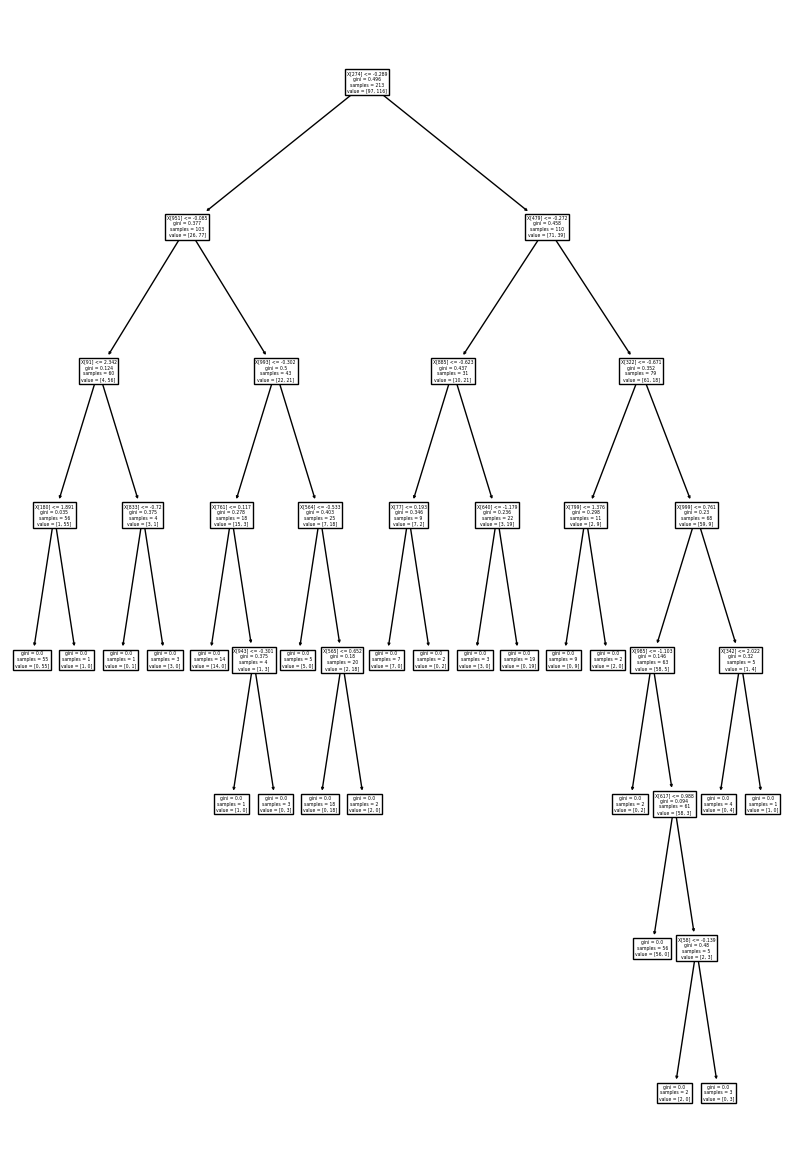

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02271596 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.02944662
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.03788247 0.         0.         0.         0.
 0.         0.         0.         0.         0. 

In [5]:
### nmr_peaks = pd.read_csv('~/Documents/IBS/NMR_data/IBS_HNMR_data_n267.csv')

# X = np.array(nmr_peaks.iloc[:, 3:])
# # #y = np.array(nmr_peaks.iloc[:, 1])
# y = pd.read_csv('~/Documents/cmr_rf/LAVASET/testing/formate_cluster_labels.txt', header=None).iloc[:, 0].to_numpy(dtype=int)
iris = datasets.load_iris()
X = iris.data[43:55]
y = iris.target[43:55]

X = np.array(nmr_peaks.iloc[:, 14000:15000])
# #y = np.array(nmr_peaks.iloc[:, 1])
y = pd.read_csv('~/Documents/cmr_rf/LAVASET/testing/formate_cluster_labels.txt', header=None).iloc[:, 0].to_numpy(dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=180)
print(X_train, y_train)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train, y_train)
model = DecisionTreeClassifier(max_features=None, splitter='best')
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(preds, y_test)
print(accuracy_score(preds, y_test))
print(classification_report(preds,y_test))

from sklearn import tree
plt.figure(figsize=(10,15))
tree.plot_tree(model)
plt.show()
print(model.feature_importances_)

In [97]:
class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees=1000, min_samples_split=3, max_depth=1000, max_samples=70):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_samples = max_samples
        # Will store individually trained decision trees
        self.decision_trees = []
    

    @staticmethod
    def _generate_sample_indices(random_state, n_samples, max_samples):
        random_instance = np.random.RandomState(random_state)
        sample_indices = random_instance.randint(0, n_samples, max_samples)
        return sample_indices

    def _parallel_build_trees(self, tree, X, y, idx):

        print("building tree %d of %d" % (idx + 1, self.num_trees))
        # Obtain data sample
        # n_rows, n_cols = X.shape
        #     # Sample with replacement
        # samples = np.random.choice(a=n_rows, size=int(n_rows/2), replace=True)
        indices = self._generate_sample_indices(idx, X.shape[0], 10)
        # # this shuffles features for max_features to be different in trees 
        # f_indices = self._generate_feature_indices(idx, X.shape[1])
        # print(f_indices)
        X_sub = X[indices, :]
        # X_sub = X_sub[:, f_indices]
        _y_sub = y[indices]
        df_train = pd.DataFrame(X_sub)
        df_train[-1] = _y_sub
        # Train
        tree.fit(X_sub, _y_sub, random_state=idx)
        # Save the classifier
        self.decision_trees.append(tree)
        return tree


    def fit(self, X, y):
        '''
        Trains a Random Forest classifier.

        :param X: np.array, features
        :param y: np.array, target
        :return: None
        '''
        n_more_dts = self.num_trees - len(self.decision_trees)
        # trees = _make_estimator(DecisionTree(), append=True)

        trees = [_make_estimator(DecisionTree(), append=False)
                for i in range(n_more_dts)
                ]

        # print('make estimator results', trees)
        trees = Parallel(
                n_jobs=-1,
                verbose=5,
                backend='multiprocessing')(delayed(self._parallel_build_trees)(tree, X, y, i) 
                for i, tree in enumerate(trees)
            )

        self.decision_trees.extend(trees)

    def predict(self, X):
        '''
        Predicts class labels for new data instances.

        :param X: np.array, new instances to predict
        :return: 
        '''
            # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))
            # Reshape so we can find the most common value
        y = np.swapaxes(a=y, axis1=0, axis2=1)

            # Use majority voting for the final prediction
        predictions = []

        for i, preds in enumerate(y):
            counter = Counter(y[i])
            predictions.append(counter.most_common(1)[0][0])
        return predictions
        
    def get_importances(self, X):
        all_importances = np.zeros(X.shape[1])
        for tree in self.decision_trees:
            importance_per_tree = np.array(tree.feature_importances_)
            # all_importances = np.concatenate(all_importances, importance_per_tree)
            all_importances = np.vstack((all_importances, importance_per_tree))

        all_importances = np.mean(all_importances, axis=0, dtype=np.float64)
        return all_importances / np.sum(all_importances)

In [ ]:
nmr_peaks = pd.read_csv('~/Documents/IBS/NMR_data/IBS_HNMR_data_n267.csv')
X = np.array(nmr_peaks.iloc[:55, 3:])
y = np.array(nmr_peaks.iloc[:55, 1])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=140)
# print(pd.DataFrame(X_train))

scaler = StandardScaler()
scaler.fit(X_train)
X_test = scaler.transform(X_test)
# model = RandomForestClassifier(n_estimators=7)
# model.fit(X_train, y_train)
# preds = model.predict(X_test)
# print(preds)
# print(accuracy_score(y_test, preds))
X_test.min()

In [ ]:
accuracy_score([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], y_test)

In [ ]:
# def add_endnode(node, left, right):
#     if left:
#         most_common_class = np.bincount(node['left'][:, -1].astype('int')).argmax()
#         node['left_node'] = {'end_node': True, 'y_hat': most_common_class}
#         del node['left']
#     if right:
#         most_common_class = np.bincount(node['right'][:, -1].astype('int')).argmax()
#         node['right_node'] = {'end_node': True, 'y_hat': most_common_class}
#         del node['right']

In [ ]:
# import sys

# def _make_estimator(base_estimator, append=True, random_state=None):
#     """Make and configure a copy of the `base_estimator_` attribute.

#     Warning: This method should be used to properly instantiate new
#     sub-estimators.
#     """
#     estimator = base_estimator
#     # estimator.set_params(**{p: getattr(self, p) for p in self.estimator_params})
    
#     estimators_= list()
#     if append:
#         estimators_.append(estimator)
#         return estimators_
#     else:
#         return estimator

# class DecisionTree:
#     def __init__(self,  min_samples_split=2, max_depth=100):

#         self.min_samples_split = min_samples_split
#         self.max_depth = max_depth
        
# def best_split (self, X, y)
#     n, m = X.shape
#     # self.n_features_ = n_cols

#     max_features = max(1, int(np.sqrt(m)))
#     X_pca = np.zeros((X.shape[0], 1))  # initiating nested array with array number = # of samples
#     # loadings = np.zeros(((5*2+1), self.max_features))
#     loadings = dict()

#     features_subset = list()
#     while len(features_subset) < max_features:
#         index = randrange(n)
#         if index not in features_subset:
#             features_subset.append(index)
#     # indexes = pd.read_csv('~/Documents/cmr_rf/nmr_knn_index2.csv')
#     indexes = pd.read_csv('~/Documents/cmr_rf/nmr_knn_index_10k1050.csv').to_numpy()
#     loadings = {}
#     scaler = StandardScaler()

#         # indexes = pd.read_csv('~/Documents/cmr_rf/nmr_knn_index_10k15k.csv')
#     for f_idx in features_subset:
#         indeces = indexes[f_idx].tolist()
#         pca_df = scaler.fit_transform(X[:, indeces])  # takes value for relevant feature in all training samples
#         # print(pd.DataFrame(pca_df))
#         pca = PCA(n_components=1)
#         X_pca = np.append(X_pca, pca.fit_transform(pca_df), axis=1)
#         loadings[f_idx] = np.ravel(pca.components_.T)

#     X_pca = X_pca[:, 1:]  # remove the 0s from initialising array
#     best_split = get_best_split(X_pca,features_subset, loadings, indexes)
#     print(pd.DataFrame(X_pca), features_subset, loadings, indexes)

# def is_pure(self, Y):
#     return np.unique(Y).size == 1

# def add_endnode(self, node, left, right):
#     if left:
#         most_common_class = np.bincount(node['left'][:, -1].astype('int')).argmax()
#         node['left_node'] = {'end_node': True, 'y_hat': most_common_class}
#         del node['left']
#     if right:
#         most_common_class = np.bincount(node['right'][:, -1].astype('int')).argmax()
#         node['right_node'] = {'end_node': True, 'y_hat': most_common_class}
#         del node['right']

# def build (self, X,y, node, depth, max_depth, max_x): # resurse tree function  
#      # CHECK Zero-Node left or right => both have same class
#     if node['left'].shape[0] == 0 or node['right'].shape[0] == 0:
#         if node['left'].shape[0] == 0:
#             node['left'] = node['right']
#         else:
#             node['right'] = node['left']
#         add_endnode(node, left=True, right=True)
#         if depth == 1:
#             return node
#         return

#     # CHECK branch depth
#     if depth >= max_depth:
#         add_endnode(node, left=True, right=True)
#         return
    
#     # CHECK max_x & convergence else: recurse further
#     if node['left'].shape[0] <= max_x or is_pure(node['left'][:, -1].astype('int')):
#         add_endnode(node, left=True, right=False)
#     else:
#         left_node = get_best_split(node['left'], features, indexes, loadings)
#         del node['left']
#         node['left_node'] = left_node
#         recurse_tree(node['left_node'], depth+1, max_depth, max_x)

#     if node['right'].shape[0] <= max_x or is_pure(node['right'][:, -1].astype('int')):
#         add_endnode(node, right=True, left=False)
#     else:
#         right_node = get_best_split(node['right'], features, indexes, loadings)
#         del node['right']
#         node['right_node'] = right_node
#         recurse_tree(node['right_node'], depth+1, max_depth, max_x)

#     # entire decision-tree
#     return node

# def fit(self, X, y):
#     data = pd.DataFrame(X)
#     data[-1] = y
#     root_node = best_split(data)
#     tree = build(root_node, 1, max_depth, max_x)
#     decision_tree.append(tree)

# class RandomForest:
#     '''
#     A class that implements Random Forest algorithm from scratch.
#     '''
#     def __init__(self, num_trees=10, min_samples_split=2, max_depth=100):
#         self.num_trees = num_trees
#         self.min_samples_split = min_samples_split
#         self.max_depth = max_depth
#         # Will store individually trained decision trees
#         # self.decision_trees = []
    
#     def pca_loading_best_split(X, y):
#         '''
#     Helper function, calculates the best split for given features and target

#     :param X: np.array, features
#     :param y: np.array or list, target
#     :return: dict
#         '''
#         n, m = X.shape
#         # self.n_features_ = n_cols

#         max_features = max(1, int(np.sqrt(m)))
#         X_pca = np.zeros((X.shape[0], 1))  # initiating nested array with array number = # of samples
#         # loadings = np.zeros(((5*2+1), self.max_features))
#         loadings = dict()

#         features_subset = list()
#         while len(features_subset) < max_features:
#             index = randrange(n)
#             if index not in features_subset:
#                 features_subset.append(index)
#         # indexes = pd.read_csv('~/Documents/cmr_rf/nmr_knn_index2.csv')
#         indexes = pd.read_csv('~/Documents/cmr_rf/nmr_knn_index_10k1050.csv').to_numpy()
#         loadings = {}
#         scaler = StandardScaler()

#             # indexes = pd.read_csv('~/Documents/cmr_rf/nmr_knn_index_10k15k.csv')
#         for f_idx in features_subset:
#             indeces = indexes[f_idx].tolist()
#             pca_df = scaler.fit_transform(X[:, indeces])  # takes value for relevant feature in all training samples
#             # print(pd.DataFrame(pca_df))
#             pca = PCA(n_components=1)
#             X_pca = np.append(X_pca, pca.fit_transform(pca_df), axis=1)
#             loadings[f_idx] = np.ravel(pca.components_.T)
            
#         X_pca = X_pca[:, 1:]  # remove the 0s from initialising array
#         best_split = get_best_split(X_pca)
#         print(pd.DataFrame(X_pca), features_subset, loadings, indexes)
#         return features_subset, X_pca, loadings, indexes

#     @staticmethod
#     def _generate_sample_indices(random_state, n_samples, max_samples=100):
#         random_instance = np.random.RandomState(random_state)
#         sample_indices = random_instance.randint(0, n_samples, 100)

#         return sample_indices


#     def _sample(X, y):
#             '''
#             Helper function used for boostrap sampling.

#             :param X: np.array, features
#             :param y: np.array, target
#             :return: tuple (sample of features, sample of target)
#             '''
#             n_rows, n_cols = X.shape
#             # Sample with replacement
#             samples = np.random.choice(a=n_rows, size=int(n_rows/2), replace=False)
#             print(samples)
#             return X[samples], y[samples]

#     def _parallel_build_trees(self, tree, X, y, idx):

#         print("building tree %d of %d" % (idx + 1, self.num_trees))
#         # Obtain data sample
#         # n_rows, n_cols = X.shape
#         #     # Sample with replacement
#         # samples = np.random.choice(a=n_rows, size=int(n_rows/2), replace=True)
#         indices = self._generate_sample_indices(idx, X.shape[0], 100)
#         X_sub = X[indices]
#         _y_sub = y[indices]
#         df_train = pd.DataFrame(X_sub)
#         df_train[-1] = _y_sub
#         # Train
#         #tree.fit(X, _y)
#         tree = create_tree(df_train.values, max_depth=10000, max_x=2)[1]
#         print(tree)
#         # predictions = decision_tree.predict(df_test.values)
#         # Save the classifier
#         #self.decision_trees.append(tree)
#         return tree


#     def fit(self, X, y):
#         '''
#         Trains a Random Forest classifier.

#         :param X: np.array, features
#         :param y: np.array, target
#         :return: None
#         '''
#         # Reset
#         # if len(self.decision_trees) > 0:
#         #     self.decision_trees = []

#         # Build each tree of the forest
#         # num_built = 0
#         self.decision_trees = []
#         n_more_dts = self.num_trees - len(self.decision_trees)
#         # trees = _make_estimator(DecisionTree(), append=True)

#         trees = [_make_estimator(create_tree, append=False)
#                 for i in range(n_more_dts)
#                 ]
#         print(trees)
#         # print('make estimator results', trees)
#         trees = Parallel(
#                 n_jobs=-1,
#                 verbose=5,
#                 backend='multiprocessing')(delayed(self._parallel_build_trees)(tree, X, y, i) 
#                 for i, tree in enumerate(trees)
#             )
#         # print(trees)
#         self.decision_trees.extend(trees)
#         print(self.decision_trees)


#     def predict_recursive(self, node, data_row):
#         if 'end_node' in node:
#             return node['y_hat']

#         if data_row[node['predictor']] < node['split_point']:
#             return self.predict_recursive(node['left_node'], data_row)
#         else:
#             return self.predict_recursive(node['right_node'], data_row)
    
#     def predict(self,data):
#         y_hat = []
#         for tree in self.decision_trees:
#             y_hat.append([self.predict_recursive(tree, x) for x in data])
#         y_hat = np.swapaxes(a=y_hat, axis1=0, axis2=1)
        
#         predictions = []
        
#         for i, preds in enumerate(y_hat):
#             counter = Counter(y_hat[i])
#             predictions.append(counter.most_common(1)[0][0])
#         return predictions



In [26]:
%%cython
# distutils: language=c++
import numpy as np
cimport numpy as np
cimport cython
from numpy cimport ndarray, float64_t, int_t
from libcpp cimport bool
from libc.math cimport ceil, sqrt
from cython.parallel import prange, parallel

# cdef int predict_recursive(node, data_row):
#     if 'end_node' in node:
#         return node['y_hat']

#     if data_row[node['predictor']] < node['split_point']:
#         return predict_recursive(node['left_node'], data_row)
#     else:
#         return predict_recursive(node['right_node'], data_row)

# cdef class DecisionTree:
#     cdef list decision_tree

#     def __cinit__(self, list decision_tree):
#         self.decision_tree = decision_tree

#     cpdef ndarray[int_t] predict(self, ndarray[float64_t, ndim=2] data):
#         cdef:
#             ndarray[int_t] predictions = np.array([], dtype=np.int)
#             int prediction
#             size_t i

#         for i in range(data.shape[0]):
#             prediction = predict_recursive(self.tree, data[i])
#             predictions = np.append(predictions, prediction)

#         return predictions

cdef int predict_recursive(node, data_row):
    if 'end_node' in node:
        return node['y_hat']

    if data_row[node['predictor']] < node['split_point']:
        return predict_recursive(node['left_node'], data_row)
    else:
        return predict_recursive(node['right_node'], data_row)


cdef class RandomForest:
    cdef list random_forest

    def __cinit__(self, list random_forest):
        self.random_forest = random_forest

    cpdef ndarray[int_t] predict(self, ndarray[float64_t, ndim=2] data):
        cdef:
            ndarray[int_t] predictions = np.array([], dtype=np.int)
            int prediction
            size_t i

        for i in range(data.shape[0]):
            prediction = self.get_random_forest_prediction(data[i])
            predictions = np.append(predictions, prediction)

        return predictions

    cdef int get_random_forest_prediction(self, data_row):
        cdef ndarray[int_t] predictions = np.array([], dtype=np.int)

        for tree in self.random_forest:
            y_hat = predict_recursive(tree, data_row)
            predictions = np.append(predictions, y_hat)
        
        return np.bincount(predictions).argmax()


'''-------------------------------------------------------------------------------------------------------'''


cdef ndarray[float64_t, ndim=2] get_bootstrap(ndarray[float64_t, ndim=2] data):
    return data[np.random.choice(data.shape[0], 100, replace=True), :]

cdef bool is_pure(ndarray[int_t, ndim=1] Y):
    return np.unique(Y).size == 1

cdef add_endnode(dict node, bool left, bool right):
    cdef int most_common_class
    if left:
        most_common_class = np.bincount(node['left'][:, -1].astype('int')).argmax()
        node['left_node'] = {'end_node': True, 'y_hat': most_common_class}
        del node['left']
    if right:
        most_common_class = np.bincount(node['right'][:, -1].astype('int')).argmax()
        node['right_node'] = {'end_node': True, 'y_hat': most_common_class}
        del node['right']


#@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
cpdef double gini_index(ndarray[float64_t, ndim=2] left, ndarray[float64_t, ndim=2] right):
    cdef:
        double purity = 0.0
        double class_ratio
        ndarray[float64_t, ndim=2] split
        ndarray[int_t, ndim=1] class_counts, unique_classes
        int total_classes, bi, i

    for bi in range(2):
        if bi == 0:
            split = left
        else:
            split = right
        
        class_counts = np.bincount(split[:, -1].astype('int'))
        unique_classes = np.array(np.nonzero(class_counts))[0]
        
        for i in range(unique_classes.shape[0]):
            class_ratio = <double>class_counts[unique_classes[i]] / split.shape[0]
            purity += class_ratio * (1 - class_ratio)
    
    return purity


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef dict get_best_split(ndarray[float64_t, ndim=2] data):
    cdef:
        ndarray[float64_t, ndim=2] left, right, b_left, b_right
        double split_point, b_split_point, gini, b_gini = 999.9
        int b_predictor, pred_i, predictor, row_i
        int num_random_predictors = <int>ceil(sqrt(data.shape[1]-1)) # size of random_predictors array
        ndarray[int_t, ndim=1] random_predictors = np.random.choice(data.shape[1]-1, num_random_predictors, replace=False)
    
    for pred_i in range(random_predictors.shape[0]):
        predictor = random_predictors[pred_i]
        # Split data 1. For every predictor value => For every row, to get best left / right split
        for row_i in range(data.shape[0]):
            split_point = data[row_i][predictor]
            left = data[data[:, predictor] < split_point]
            right = data[data[:, predictor] >= split_point]
            
            gini = gini_index(left, right)

            if gini < b_gini:
                b_gini, b_split_point, b_predictor = gini, split_point, predictor
                b_left, b_right = left.copy(), right.copy()

    # TODO add proportional gini change for Variable-Importance measure
    return {'left': b_left, 'right': b_right, 'split_point': b_split_point, 'predictor': b_predictor, 'gini': b_gini}


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef dict recurse_tree(dict node, int depth, int max_depth, int max_x):
    cdef:
        dict left_node, right_node

    # CHECK Zero-Node left or right => both have same class
    if node['left'].shape[0] == 0 or node['right'].shape[0] == 0:
        if node['left'].shape[0] == 0:
            node['left'] = node['right']
        else:
            node['right'] = node['left']
        add_endnode(node, left=True, right=True)
        if depth == 1:
            return node
        return

    # CHECK branch depth
    if depth >= max_depth:
        add_endnode(node, left=True, right=True)
        return
    
    # CHECK max_x & convergence else: recurse further
    if node['left'].shape[0] <= max_x or is_pure(node['left'][:, -1].astype('int')):
        add_endnode(node, left=True, right=False)
    else:
        left_node = get_best_split(node['left'])
        del node['left']
        node['left_node'] = left_node
        recurse_tree(node['left_node'], depth+1, max_depth, max_x)


    if node['right'].shape[0] <= max_x or is_pure(node['right'][:, -1].astype('int')):
        add_endnode(node, right=True, left=False)
    else:
        right_node = get_best_split(node['right'])
        del node['right']
        node['right_node'] = right_node
        recurse_tree(node['right_node'], depth+1, max_depth, max_x)

    # entire decision-tree
    return node


# labels have to be last column
cpdef create_forest(ndarray[float64_t, ndim=2] data, int n_trees, int max_depth, int max_x):
    cdef:
        list random_forest = []
        dict tree, root_node
        # ndarray[float64_t, ndim=2] subsample
        # ndarray[float64_t, ndim=2] subsample2
        # ndarray[float64_t, ndim=2] subsample3
        # ndarray[float64_t, ndim=2] subsample_all
        size_t i
    # with nogil, parallel(num_threads=8):
    for i in range(n_trees):
        print("building tree %d of %d" % (i, n_trees))
        # subsample = get_bootstrap(data)
        # subsample2 = get_bootstrap(data)
        # subsample3 = get_bootstrap(data)
        # subsample_all = np.array(subsample, subsample2, subsample3)     
        # with nogil, parallel(num_threads=12):
        # root_node = get_best_split(subsample_all[i])
        root_node = get_best_split(get_bootstrap(data))
        tree = recurse_tree(root_node, 1, max_depth, max_x)
        print(tree)
        random_forest.append(tree)
    
    return RandomForest(random_forest)




cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/mk218/.cache/ipython/cython/_cython_magic_82f70519bea0eedf9ca95addada78092.cpp:743:
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/home/mk218/.cache/ipython/cython/_cython_magic_82f70519bea0eedf9ca95addada78092.cpp: In 

In [27]:
# test gini_index
from datetime import datetime

# test get_best_split
nmr_peaks = pd.read_csv('~/Documents/IBS/NMR_data/IBS_HNMR_data_n267.csv')
# X = nmr_peaks.iloc[:, 15000:15500]
# X = np.array(nmr_peaks.iloc[:, 3:])

X = np.array(nmr_peaks.iloc[:80, 3:1000])
# print(pd.DataFrame(X))
# y = np.array(nmr_peaks.iloc[:, 2])
y = np.array(nmr_peaks.iloc[:80, 1])


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=70)
# print(pd.DataFrame(X_train))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df_train = pd.DataFrame(X_train)
df_train[-1] = y_train
display(df_train.shape)
df_test = pd.DataFrame(X_test)
df_test[-1] = y_test
df_test
# split_data = get_best_split(df2.values)
#print(split_data)
# print(datetime.now())
start = time.perf_counter()
model = RandomForest()
model.fit(X_train, y_train)
# decision_tree = create_tree(df_train.values, max_depth=10000, max_x=2)[0]
predictions = model.predict(df_test.values)
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))
# for i in range(1000):
#     split_data = get_best_split(df.values)

# print(datetime.now())

# # test create_tree / recurse_tree
# #print(create_tree(df.as_matrix(), n_trees=2, max_depth=3, max_x=5))
# train_data, test_data = df.iloc[:120, [3, 4, -1]].as_matrix(), df.iloc[120:, [3, 4, -1]].as_matrix()
# random_forest = create_forest(train_data, n_trees=450, max_depth=15, max_x=3)
# predictions = random_forest.predict(test_data)

# correct = 0
# for i in range(len(predictions)):
#     if predictions[i] == df.iloc[120+i, -1]:
#         correct += 1
    
# print(predictions)
# print("Ratio Correct:", correct / len(predictions))

(64, 998)

TypeError: __cinit__() takes exactly 1 positional argument (0 given)

In [ ]:
predictions 

In [ ]:
y_test

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, predictions))